In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, isnan, when, count
import pandas as pd
import numpy as np

In [1]:
### 1. Load Data

# 1. Create Spark session
spark = SparkSession.builder.appName("CustomerChurn").getOrCreate()  
# Initializes a Spark session for the application.

# 2. Load dataset from CSV
data = spark.read.csv('Data/iris.csv', header=True, inferSchema=True)  
# Reads 'iris.csv', uses first row as column names, and infers column data types.

# 3. Show first 10 rows
data.show(10)  
# Displays the first 10 rows of the dataset for a quick preview.

NameError: name 'SparkSession' is not defined

In [3]:
#2. EDA

from pyspark.sql.functions import col, sum

# Count null values in each column
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()  
# 'isNull()' checks for null values, 'cast("int")' converts the boolean to integers (0 or 1), and 'sum()' totals them.
# This shows the number of null values in each column.

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|           0|          0|           0|          0|      0|
+------------+-----------+------------+-----------+-------+



In [11]:
## 3. Look at missing values and outliers
# Check for missing values in each column
for col in data.columns:
    data.select(col).filter(data[col].isNull()).show()  # Empty set, no missing values to handle
# Loops through each column, filters for null values, and shows rows with missing values (if any).

+------------+
|sepal_length|
+------------+
+------------+

+-----------+
|sepal_width|
+-----------+
+-----------+

+------------+
|petal_length|
+------------+
+------------+

+-----------+
|petal_width|
+-----------+
+-----------+

+-------+
|species|
+-------+
+-------+



In [4]:
# 1. Print schema of the dataset
data.printSchema()  
# Displays the column names and their data types to understand the structure of the data.

# 2. Show summary statistics for numeric columns
data.describe().show()  
# Provides count, mean, stddev, min, and max for numerical columns, giving insight into data distribution.

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)

+-------+------------------+-------------------+------------------+------------------+---------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|  species|
+-------+------------------+-------------------+------------------+------------------+---------+
|  count|               150|                150|               150|               150|      150|
|   mean| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|     NULL|
| stddev|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|     NULL|
|    min|               4.3|                2.0|               1.0|               0.1|   setosa|
|    max|               7.9|                4.4|               6.9|               2.5|virginica|
+----

In [5]:
# Group data by 'species' and count occurrences
data.groupBy("species").count().orderBy("species").show()  
# Groups the dataset by the 'species' column, counts the occurrences for each group, 
# and orders the results by species.

+----------+-----+
|   species|count|
+----------+-----+
|    setosa|   50|
|versicolor|   50|
| virginica|   50|
+----------+-----+



In [12]:
# According to the dataset structure, Churn should be only "Yes" or "No", otherwise will be outliers
data.filter((data["Churn"] != "Yes" ) & (data["Churn"] != "No")).show() # Empty set, no outlier to handle

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
+------------+-----------+------------+-----------+-------+



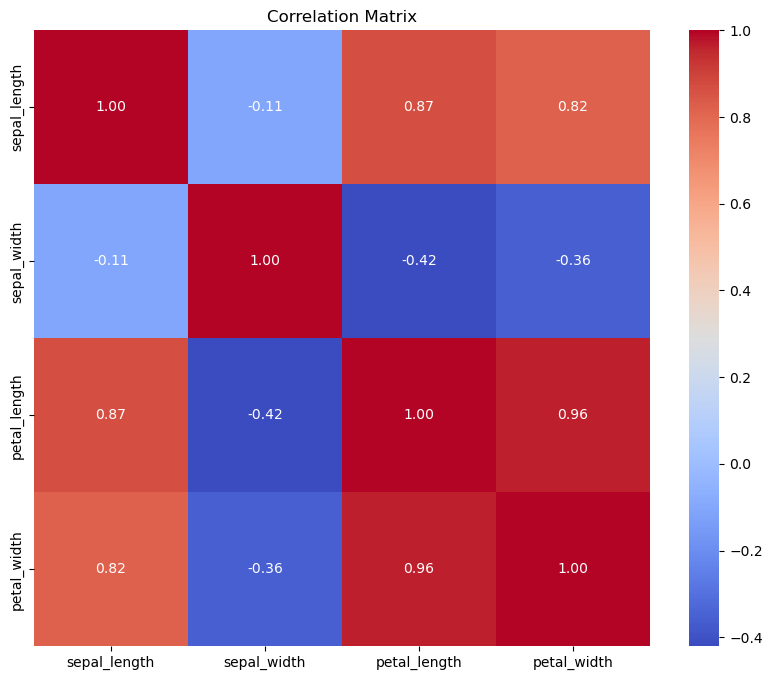

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = data.toPandas()

# Select only numerical columns for correlation matrix (exclude non-numeric columns like 'species')
numerical_columns = pandas_df.select_dtypes(include=[np.number]).columns

# Calculate the correlation matrix
correlation_matrix = pandas_df[numerical_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()


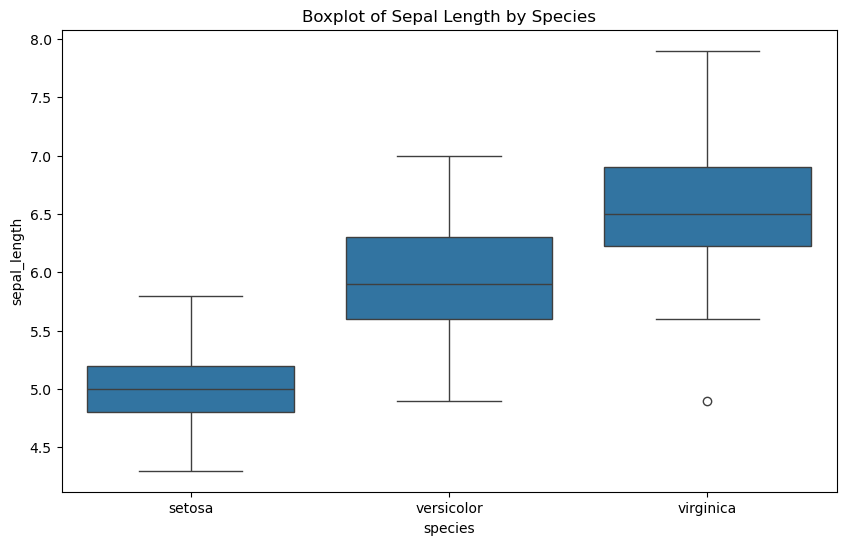

In [6]:
# Find any outlier

import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_df = data.toPandas()

# Create a boxplot for each numerical column, grouped by 'species'
plt.figure(figsize=(10, 6))
sns.boxplot(x='species', y='sepal_length', data=pandas_df)  # You can replace 'sepal_length' with any numerical column
plt.title('Boxplot of Sepal Length by Species')
plt.show()

In [7]:
#3. Deal with missing value and outliers

from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"],
                    outputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"]).setStrategy("mean")
iris_imputed = imputer.fit(data).transform(data)
iris_imputed.show(5)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows



In [28]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Step 1: Convert 'species' (string) to numeric 'label' using StringIndexer
indexer = StringIndexer(inputCol="species", outputCol="label")
iris_indexed = indexer.fit(iris_imputed).transform(iris_imputed)
# 'species' is now a numeric column 'label'

# Step 2: Combine feature columns into a single vector column 'raw_features' using VectorAssembler
assembler = VectorAssembler(inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"], outputCol="raw_features")
assembled = assembler.transform(iris_indexed)
# 'sepal_length', 'sepal_width', 'petal_length', 'petal_width' are now combined into 'raw_features'

In [61]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Step 3: Normalize the features using StandardScaler
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
iris_scaled = scaler.fit(assembled).transform(assembled)
#scaler = MinMaxScaler(inputCol="features", outputCol="scaled_data")

# Step 4: Display all columns including scaled features
iris_scaled.select("features", "label").show(5)
iris_scaled.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.8976738791967...|  0.0|
|[-1.1392004834649...|  0.0|
|[-1.3807270877331...|  0.0|
|[-1.5014903898672...|  0.0|
|[-1.0184371813308...|  0.0|
+--------------------+-----+
only showing top 5 rows

+------------+-----------+------------+-----------+-------+-----+-----------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|species|label|     raw_features|            features|
+------------+-----------+------------+-----------+-------+-----+-----------------+--------------------+
|         5.1|        3.5|         1.4|        0.2| setosa|  0.0|[5.1,3.5,1.4,0.2]|[-0.8976738791967...|
|         4.9|        3.0|         1.4|        0.2| setosa|  0.0|[4.9,3.0,1.4,0.2]|[-1.1392004834649...|
|         4.7|        3.2|         1.3|        0.2| setosa|  0.0|[4.7,3.2,1.3,0.2]|[-1.3807270877331...|
|         4.6|        3.1|         1.5|        0.2| setosa|  0.0|[4.6,3.1,1.5,0.2]|[

In [62]:
from pyspark.ml.feature import StandardScaler

# Step 4: Normalize the feature data by scaling it to have zero mean and unit variance
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
data_scaled = scaler.fit(assembled).transform(assembled)

# Display the scaled features and the corresponding labels
data_scaled.select("features", "label").show(5)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.8976738791967...|  0.0|
|[-1.1392004834649...|  0.0|
|[-1.3807270877331...|  0.0|
|[-1.5014903898672...|  0.0|
|[-1.0184371813308...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [63]:
# Dimension reduction

from pyspark.ml.feature import PCA

# Perform PCA with 2 components
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(data_scaled)  # Fit PCA model
data_pca = pca_model.transform(data_scaled)  # Apply PCA transformation

# Show the PCA features and label (first 5 rows)
data_pca.select("pca_features", "label").show(5, truncate=False)

+----------------------------------------+-----+
|pca_features                            |label|
+----------------------------------------+-----+
|[2.2569806330680264,-0.5040154042276581]|0.0  |
|[2.0794591188954032,0.6532163936125837] |0.0  |
|[2.360044081584208,0.31741394457027705] |0.0  |
|[2.296503660003885,0.5734466129712273]  |0.0  |
|[2.3808015864527436,-0.6725144107910821]|0.0  |
+----------------------------------------+-----+
only showing top 5 rows



In [54]:
# Accessing the variance explained by each component
variance_explained = pca_model.explainedVariance
print(f"Variance explained by each component: {variance_explained}")

Variance explained by each component: [0.7277045209380137,0.23030523267680608]


In [55]:
# Split dataset into 70% training and 30% testing
train_data, test_data = iris_scaled.randomSplit([0.7, 0.3], seed=42)

# Display the count of records in the training and testing sets
print("Training: " + str(train_data.count()) + ", Testing: " + str(test_data.count()))

Training: 104, Testing: 46


In [60]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the Logistic Regression model
lr = LogisticRegression(maxIter=10)

# Set up the parameter grid for hyperparameter tuning
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Define the evaluator for model performance evaluation (based on accuracy)
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# Set up CrossValidator for hyperparameter tuning using 3-fold cross-validation
lr_cv = CrossValidator(estimator=lr, 
                       estimatorParamMaps=lr_param_grid, 
                       evaluator=evaluator, 
                       numFolds=3)

# Train the model with cross-validation
lr_cv_model = lr_cv.fit(train_data)

# Make predictions on the test data
lr_cv_predictions = lr_cv_model.transform(test_data)

# Show predictions along with actual labels
lr_cv_predictions.select("sepal_length", "sepal_width", "petal_length", "petal_width", "species", "prediction").show(5)

# Evaluate the model's accuracy on the test data
test_accuracy = evaluator.evaluate(lr_cv_predictions)  # Calculate accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")  # Print the accuracy value

# Extract and print the best model's hyperparameters after cross-validation
best_model = lr_cv_model.bestModel  # Get the best model (with the best hyperparameters)
print("Best Model's Hyperparameters:")
print(f"Regularization parameter (regParam): {best_model.getRegParam()}")
print(f"ElasticNet parameter (elasticNetParam): {best_model.getElasticNetParam()}")

+------------+-----------+------------+-----------+-------+----------+
|sepal_length|sepal_width|petal_length|petal_width|species|prediction|
+------------+-----------+------------+-----------+-------+----------+
|         4.4|        3.0|         1.3|        0.2| setosa|       0.0|
|         4.6|        3.2|         1.4|        0.2| setosa|       0.0|
|         4.6|        3.6|         1.0|        0.2| setosa|       0.0|
|         4.7|        3.2|         1.3|        0.2| setosa|       0.0|
|         4.8|        3.1|         1.6|        0.2| setosa|       0.0|
+------------+-----------+------------+-----------+-------+----------+
only showing top 5 rows

Test Accuracy: 0.9783
Best Model's Hyperparameters:
Regularization parameter (regParam): 0.01
ElasticNet parameter (elasticNetParam): 0.0


In [69]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

# Hyperparameter grid for Random Forest
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxDepth, [3, 5, 8]) \
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
    .build()

# CrossValidator for Random Forest with 3-fold cross-validation
rf_cv = CrossValidator(estimator=rf,
                       estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator,
                       numFolds=3)

# Fitting the model with cross-validation
rf_cv_model = rf_cv.fit(train_data)

# Transform the test data with the best model
rf_cv_predictions = rf_cv_model.transform(test_data)

# Evaluate the model on different metrics
for metric in ["accuracy", "weightedPrecision", "weightedRecall", "f1"]:
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=metric)
    score = evaluator.evaluate(rf_cv_predictions)
    print(f"{metric.capitalize()}: {score:.4f}")

# Show predictions on the test data
rf_cv_predictions.select("sepal_length", "sepal_width", "petal_length", "petal_width", "species", "prediction", "probability").show(5, truncate=False)


Accuracy: 0.9783
Weightedprecision: 0.9804
Weightedrecall: 0.9783
F1: 0.9785
+------------+-----------+------------+-----------+-------+----------+---------------+
|sepal_length|sepal_width|petal_length|petal_width|species|prediction|probability    |
+------------+-----------+------------+-----------+-------+----------+---------------+
|4.4         |3.0        |1.3         |0.2        |setosa |0.0       |[1.0,0.0,0.0]  |
|4.6         |3.2        |1.4         |0.2        |setosa |0.0       |[1.0,0.0,0.0]  |
|4.6         |3.6        |1.0         |0.2        |setosa |0.0       |[1.0,0.0,0.0]  |
|4.7         |3.2        |1.3         |0.2        |setosa |0.0       |[1.0,0.0,0.0]  |
|4.8         |3.1        |1.6         |0.2        |setosa |0.0       |[0.95,0.05,0.0]|
+------------+-----------+------------+-----------+-------+----------+---------------+
only showing top 5 rows



In [68]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", seed=42)

# Hyperparameter grid for Decision Tree
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 8]) \
    .addGrid(dt.minInstancesPerNode, [1, 2, 5]) \
    .build()

# CrossValidator for Decision Tree with 3-fold cross-validation
dt_cv = CrossValidator(estimator=dt,
                       estimatorParamMaps=dt_param_grid,
                       evaluator=evaluator,
                       numFolds=3)

# Fitting the model with cross-validation
dt_cv_model = dt_cv.fit(train_data)

# Transform the test data with the best model
dt_cv_predictions = dt_cv_model.transform(test_data)

# Evaluate the model on different metrics
for metric in ["accuracy", "weightedPrecision", "weightedRecall", "f1"]:
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=metric)
    score = evaluator.evaluate(dt_cv_predictions)
    print(f"{metric.capitalize()}: {score:.4f}")

# Show predictions on the test data
dt_cv_predictions.select("sepal_length", "sepal_width", "petal_length", "petal_width", "species", "prediction", "probability").show(5, truncate=False)


Accuracy: 0.9783
Weightedprecision: 0.9804
Weightedrecall: 0.9783
F1: 0.9785
+------------+-----------+------------+-----------+-------+----------+-------------+
|sepal_length|sepal_width|petal_length|petal_width|species|prediction|probability  |
+------------+-----------+------------+-----------+-------+----------+-------------+
|4.4         |3.0        |1.3         |0.2        |setosa |0.0       |[1.0,0.0,0.0]|
|4.6         |3.2        |1.4         |0.2        |setosa |0.0       |[1.0,0.0,0.0]|
|4.6         |3.6        |1.0         |0.2        |setosa |0.0       |[1.0,0.0,0.0]|
|4.7         |3.2        |1.3         |0.2        |setosa |0.0       |[1.0,0.0,0.0]|
|4.8         |3.1        |1.6         |0.2        |setosa |0.0       |[1.0,0.0,0.0]|
+------------+-----------+------------+-----------+-------+----------+-------------+
only showing top 5 rows



In [74]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Logistic Regression Classifier
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, family="multinomial")

# Hyperparameter grid for Logistic Regression
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# CrossValidator for Logistic Regression with 3-fold cross-validation
lr_cv = CrossValidator(estimator=lr,
                       estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator,
                       numFolds=3)

# Fitting the model with cross-validation
lr_cv_model = lr_cv.fit(train_data)

# Transform the test data with the best model
lr_cv_predictions = lr_cv_model.transform(test_data)

# Evaluate the model on different metrics
for metric in ["accuracy", "weightedPrecision", "weightedRecall", "f1"]:
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=metric)
    score = evaluator.evaluate(lr_cv_predictions)
    print(f"{metric.capitalize()}: {score:.4f}")

# Show predictions on the test data
lr_cv_predictions.select("sepal_length", "sepal_width", "petal_length", "petal_width", "species", "prediction", "probability").show(5, truncate=False)


Exception ignored in: <function JavaWrapper.__del__ at 0x0000022BBEA0C860>
Traceback (most recent call last):
  File "C:\Users\PC 14\anaconda3\Lib\site-packages\pyspark\ml\wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'LogisticRegression' object has no attribute '_java_obj'


Accuracy: 0.9783
Weightedprecision: 0.9804
Weightedrecall: 0.9783
F1: 0.9785
+------------+-----------+------------+-----------+-------+----------+---------------------------------------------------------------+
|sepal_length|sepal_width|petal_length|petal_width|species|prediction|probability                                                    |
+------------+-----------+------------+-----------+-------+----------+---------------------------------------------------------------+
|4.4         |3.0        |1.3         |0.2        |setosa |0.0       |[0.972735801478957,0.027263558438403144,6.400826399639348E-7]  |
|4.6         |3.2        |1.4         |0.2        |setosa |0.0       |[0.9755225478259448,0.02447693195671428,5.202173410077671E-7]  |
|4.6         |3.6        |1.0         |0.2        |setosa |0.0       |[0.9942881759922221,0.0057117766242417555,4.738353615383053E-8]|
|4.7         |3.2        |1.3         |0.2        |setosa |0.0       |[0.9729072119658756,0.027092293026620973,4.

In [81]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the models
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, family="multinomial")

# Hyperparameter grid for Decision Tree
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 8]) \
    .addGrid(dt.minInstancesPerNode, [1, 2, 5]) \
    .build()

# Hyperparameter grid for Random Forest
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxDepth, [3, 5, 8]) \
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt", "log2"]) \
    .build()

# Hyperparameter grid for Logistic Regression
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Function to evaluate models and print metrics
def evaluate_model(model_name, model, param_grid, train_data, test_data, evaluator):
    print(f"\n{'='*20} {model_name} {'='*20}")
    
    # Cross-Validation for hyperparameter tuning
    cv = CrossValidator(estimator=model,
                        estimatorParamMaps=param_grid,
                        evaluator=evaluator,
                        numFolds=3)
    
    # Fit the model
    cv_model = cv.fit(train_data)
    
    # Make predictions
    predictions = cv_model.transform(test_data)
    
    # Metrics to evaluate
    metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]
    
    # Print the evaluation metrics
    evaluation_results = {}
    for metric in metrics:
        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=metric)
        score = evaluator.evaluate(predictions)
        evaluation_results[metric] = score
        print(f"{metric.capitalize()}: {score:.4f}")
    
    # Show predictions
    predictions.select("sepal_length", "sepal_width", "petal_length", "petal_width", "species", "prediction", "probability").show(5, truncate=False)

    return evaluation_results

# Evaluate Decision Tree
dt_results = evaluate_model("Decision Tree", dt, dt_param_grid, train_data, test_data, evaluator)

# Evaluate Random Forest
rf_results = evaluate_model("Random Forest", rf, rf_param_grid, train_data, test_data, evaluator)

# Evaluate Logistic Regression
lr_results = evaluate_model("Logistic Regression", lr, lr_param_grid, train_data, test_data, evaluator)

# Combine all results
combined_results = {
    "Decision Tree": dt_results,
    "Random Forest": rf_results,
    "Logistic Regression": lr_results
}

# Show combined results
from pprint import pprint
print("\nCombined Evaluation Results:")
pprint(combined_results)



==================== Decision Tree ====================
Accuracy: 0.9783
Weightedprecision: 0.9804
Weightedrecall: 0.9783
F1: 0.9785
+------------+-----------+------------+-----------+-------+----------+-------------+
|sepal_length|sepal_width|petal_length|petal_width|species|prediction|probability  |
+------------+-----------+------------+-----------+-------+----------+-------------+
|4.4         |3.0        |1.3         |0.2        |setosa |0.0       |[1.0,0.0,0.0]|
|4.6         |3.2        |1.4         |0.2        |setosa |0.0       |[1.0,0.0,0.0]|
|4.6         |3.6        |1.0         |0.2        |setosa |0.0       |[1.0,0.0,0.0]|
|4.7         |3.2        |1.3         |0.2        |setosa |0.0       |[1.0,0.0,0.0]|
|4.8         |3.1        |1.6         |0.2        |setosa |0.0       |[1.0,0.0,0.0]|
+------------+-----------+------------+-----------+-------+----------+-------------+
only showing top 5 rows


==================== Random Forest ====================
Accuracy: 0.9783
We

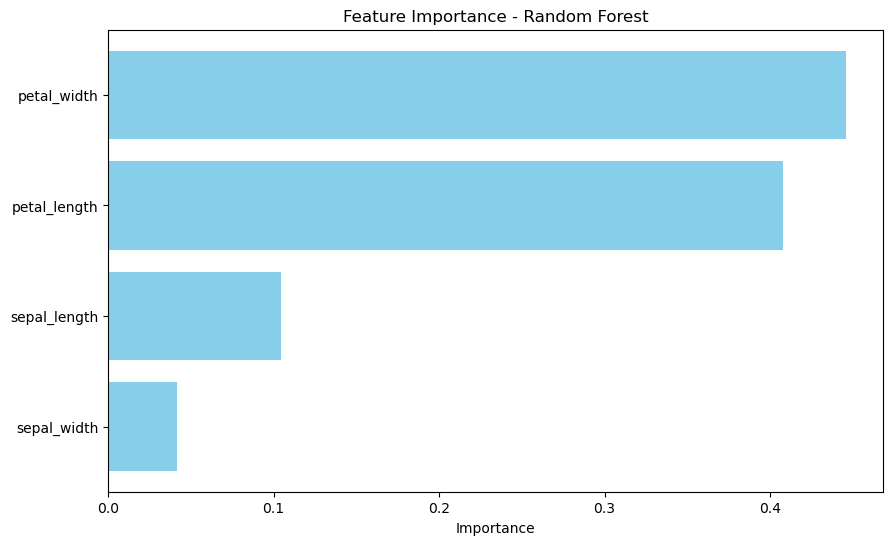

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming your data is already loaded into `train_data` and `test_data`
# Define the feature columns for VectorAssembler
feature_columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]  # adjust this to match your dataset

# Rename the output column to avoid conflicts with the existing "features" column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")

# Train a RandomForest model
rf = RandomForestClassifier(featuresCol="assembled_features", labelCol="label", seed=42)

# Combine the assembler and the model in a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Fit the model
model = pipeline.fit(train_data)
rf_model = model.stages[-1]  # Get the RandomForest model (the last stage)

# Get the feature importances
importances = rf_model.featureImportances

# Convert the feature importances into a pandas DataFrame
importances_df = pd.DataFrame(list(zip(feature_columns, importances.toArray())), columns=["Feature", "Importance"])

# Sort the features by importance
importances_df = importances_df.sort_values(by="Importance", ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances_df["Feature"], importances_df["Importance"], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance - Random Forest")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


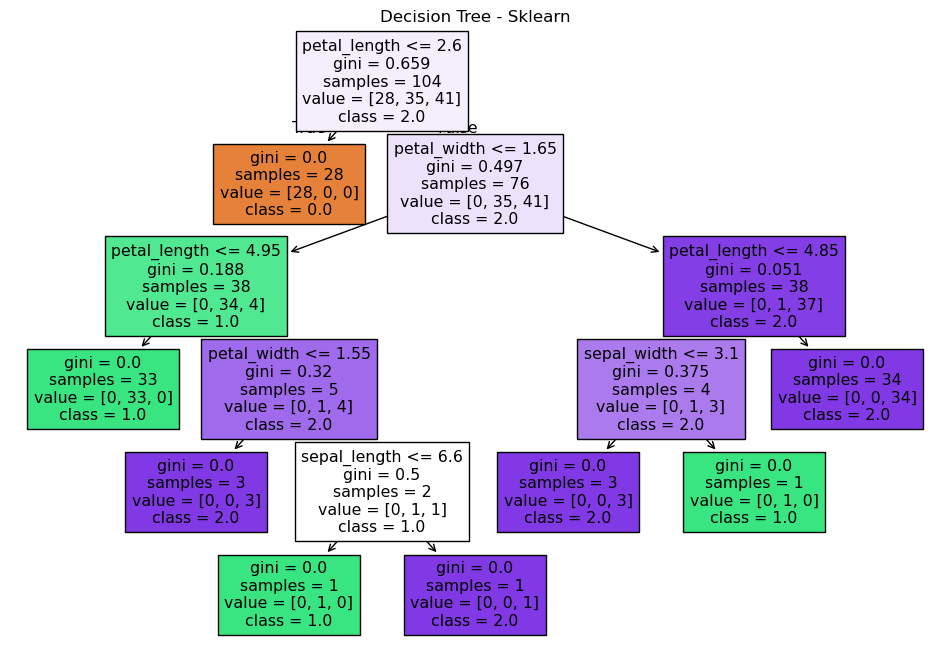

In [96]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTree
from sklearn.tree import plot_tree
import pandas as pd
import numpy as np

# Assuming `train_data` is your training dataset
# Define the feature columns
feature_columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"]  # adjust this to match your dataset

# Assemble the features into a vector column (avoid using "features" as outputCol)
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")

# Train a Decision Tree model in PySpark
dt = DecisionTreeClassifier(featuresCol="assembled_features", labelCol="label", maxDepth=5)

# Combine the assembler and the model into a pipeline
pipeline = Pipeline(stages=[assembler, dt])

# Fit the model
model = pipeline.fit(train_data)
dt_model = model.stages[-1]  # Extract the trained Decision Tree model (last stage of the pipeline)

# Extract the training data (features and labels) for sklearn
train_data_pd = train_data.select(feature_columns + ['label']).toPandas()

X_train = train_data_pd[feature_columns].values
y_train = train_data_pd['label'].values

# Train a scikit-learn Decision Tree Classifier using the same data
sklearn_dt = SklearnDecisionTree(max_depth=5)
sklearn_dt.fit(X_train, y_train)

# Plot the decision tree using sklearn's plot_tree function
plt.figure(figsize=(12, 8))
plot_tree(sklearn_dt, feature_names=feature_columns, class_names=np.unique(y_train).astype(str), filled=True)
plt.title("Decision Tree - Sklearn")
plt.show()



Evaluating Decision Tree...


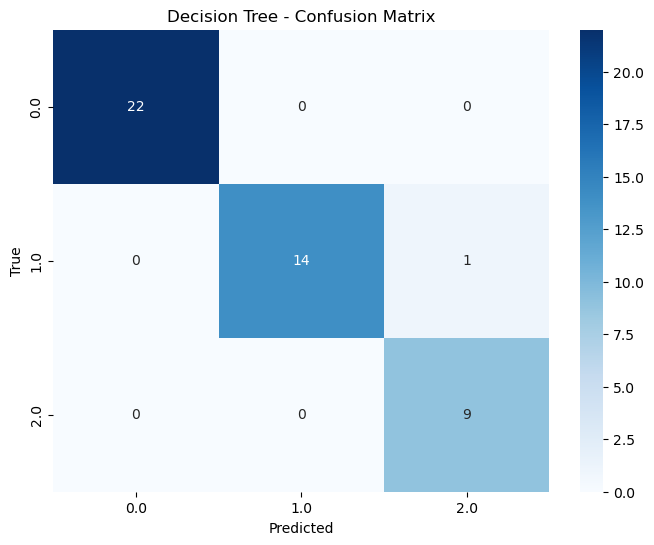

Decision Tree Accuracy: 0.9783

Evaluating Random Forest...


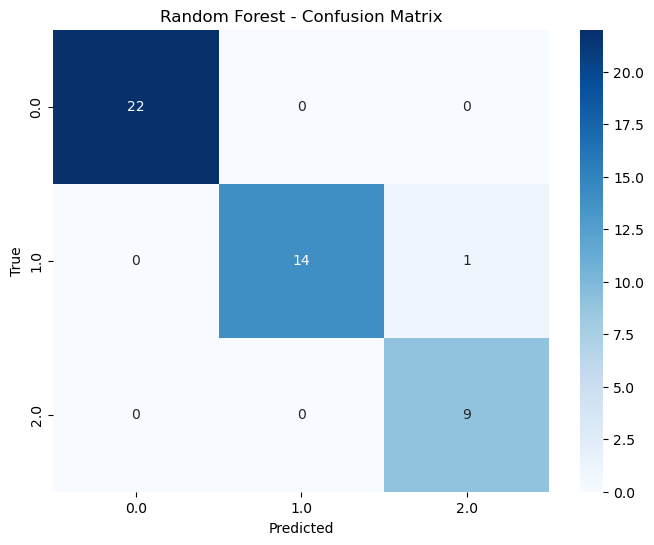

Random Forest Accuracy: 0.9783

Evaluating Logistic Regression...


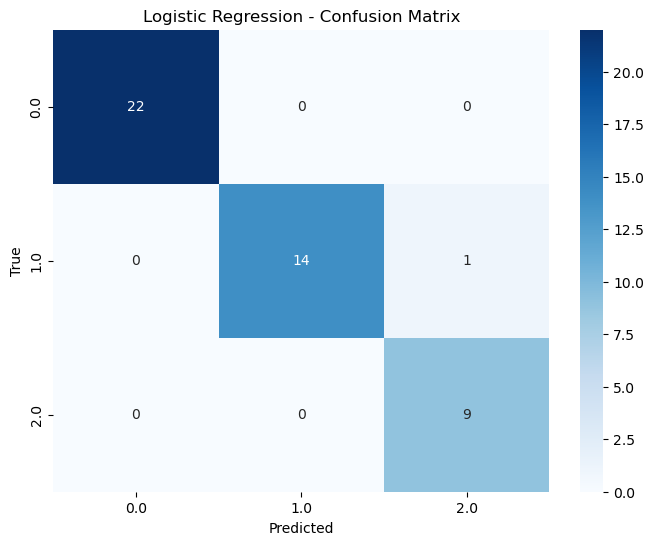

Logistic Regression Accuracy: 0.9783


In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# Define models
dt = DecisionTreeClassifier(featuresCol="assembled_features", labelCol="label")
rf = RandomForestClassifier(featuresCol="assembled_features", labelCol="label", seed=42)
lr = LogisticRegression(featuresCol="assembled_features", labelCol="label", maxIter=10, family="multinomial")

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Function to evaluate and plot confusion matrix
def evaluate_and_plot_confusion_matrix(model_name, model, train_data, test_data, evaluator):
    print(f"\nEvaluating {model_name}...")

    # Fit the model on training data
    pipeline = Pipeline(stages=[assembler, model])
    fitted_model = pipeline.fit(train_data)

    # Make predictions
    predictions = fitted_model.transform(test_data)

    # Get confusion matrix
    y_true = predictions.select("label").toPandas()
    y_pred = predictions.select("prediction").toPandas()
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Return accuracy score
    accuracy = evaluator.evaluate(predictions)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

# Evaluate Decision Tree
evaluate_and_plot_confusion_matrix("Decision Tree", dt, train_data, test_data, evaluator)

# Evaluate Random Forest
evaluate_and_plot_confusion_matrix("Random Forest", rf, train_data, test_data, evaluator)

# Evaluate Logistic Regression
evaluate_and_plot_confusion_matrix("Logistic Regression", lr, train_data, test_data, evaluator)


In [226]:
## 4. Convert step (using list way)

label_indexer = StringIndexer(inputCol="Churn", outputCol="label")

# Define categorical and numerical columns
categorical_cols = ['gender','Partner','Dependents','PhoneService','MultipleLines',
                    'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
                    'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling',
                    'PaymentMethod']

numerical_cols = ['SeniorCitizen','tenure','MonthlyCharges','TotalCharges']


In [228]:
# Give feature a label(numerical):
for col in categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_label")
    data = indexer.fit(data).transform(data)
data.show(10)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|gender_label|Partner_label|Dependents_label|PhoneService_label|MultipleLines_label|InternetService_label|OnlineSecurity_label|OnlineBackup_label|DeviceProtection

In [229]:
## 5. Split step
train_data, test_data = data.randomSplit([0.8, 0.2], seed=666)

In [232]:
### b) Feature Engineering
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

## 1. New label features
# Already get new _label features in above step

## 2. Select relevant features based on domain knowledge
key_cols=['Partner','Dependents','PhoneService','MultipleLines',
                    'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
                    'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling',
                    'PaymentMethod']

key_numerical_cols=['SeniorCitizen','tenure','MonthlyCharges']

## 3. Feature vector
assembler_inputs = [col + "_label" for col in key_cols] + key_numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")


In [178]:
data_vec = assembler.transform(data)

In [184]:
## 4. Normalize rating
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_data")
scaler_model = scaler.fit(data_vec)
data_scaled = scaler_model.transform(data_vec)


In [186]:
data_scaled.select("customerID", "scaled_data").show(10)

+----------+--------------------+
|customerID|         scaled_data|
+----------+--------------------+
|7590-VHVEG|(17,[0,2,3,4,6,15...|
|5575-GNVDE|(17,[4,5,7,11,12,...|
|3668-QPYBK|(17,[4,5,6,13,15,...|
|7795-CFOCW|[0.0,0.0,1.0,1.0,...|
|9237-HQITU|(17,[15,16],[0.02...|
|9305-CDSKC|(17,[3,7,9,10,15,...|
|1452-KIOVK|(17,[1,3,6,9,13,1...|
|6713-OKOMC|(17,[2,3,4,5,12,1...|
|7892-POOKP|(17,[0,3,7,8,9,10...|
|6388-TABGU|(17,[1,4,5,6,11,1...|
+----------+--------------------+
only showing top 10 rows



In [188]:
## 5. PCA
from pyspark.ml.feature import PCA

pca = PCA(k=3, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(data_vec)
data_pca = pca_model.transform(data_vec)
data_pca.select("customerID", "pca_features").show(10, truncate=False)

+----------+-----------------------------------------------------------+
|customerID|pca_features                                               |
+----------+-----------------------------------------------------------+
|7590-VHVEG|[-27.406691178016334,11.693790868578565,1.1969727088506252]|
|5575-GNVDE|[-65.92985815796929,-6.727223526642739,2.707176250522056]  |
|3668-QPYBK|[-49.520899117989934,20.940307086484992,3.1083642143072026]|
|7795-CFOCW|[-57.35010884651055,-22.929783459084042,1.7980282699980046]|
|9237-HQITU|[-64.80325489013778,28.14919500187816,2.824674190910207]   |
|9305-CDSKC|[-93.52016716553062,34.94429258733854,4.8852894966922795]  |
|1452-KIOVK|[-89.93973205142214,17.762948723375242,4.04167982216013]   |
|6713-OKOMC|[-31.133151982310405,3.494643572100136,1.0900020120929679] |
|7892-POOKP|[-106.67147667432033,19.014496930306297,4.950745626065711] |
|6388-TABGU|[-77.10861552968844,-32.41372180314005,2.061728739797676]  |
+----------+---------------------------------------

In [236]:
### c) Model Implementation & d) Evaluation and Discussion
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression

def evaluate_model(model_name, model, train_data, test_data, param_grid):
    print(f"\n{'='*20} {model_name} {'='*20}")
    pipeline = Pipeline(stages=indexers + encoders + [label_indexer, assembler, model])

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

    cv = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=param_grid,
                        evaluator=evaluator,
                        numFolds=3)

    cv_model = cv.fit(train_data)
    predictions = cv_model.transform(test_data)

    # Evaluation metrics
    for metric in ["accuracy", "weightedPrecision", "weightedRecall", "f1"]:
        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName=metric)
        score = evaluator.evaluate(predictions)
        print(f"{metric.capitalize()}: {score:.4f}")

    # Show predictions
    predictions.select("customerID", "label", "prediction", "probability").show(5, truncate=False)


# ========== 1. Decision Tree ==========
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [3, 5, 10]) \
    .addGrid(dt.minInstancesPerNode, [1, 5]) \
    .build()

evaluate_model("Decision Tree", dt, train_data, test_data, dt_param_grid)


# ========== 2. Random Forest ==========
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

evaluate_model("Random Forest", rf, train_data, test_data, rf_param_grid)


# ========== 3. Logistic Regression ==========
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluate_model("Logistic Regression", lr, train_data, test_data, lr_param_grid)




==================== Decision Tree ====================
Accuracy: 0.8025
Weightedprecision: 0.7979
Weightedrecall: 0.8025
F1: 0.7998
+----------+-----+----------+----------------------------------------+
|customerID|label|prediction|probability                             |
+----------+-----+----------+----------------------------------------+
|0023-XUOPT|1.0  |1.0       |[0.36261980830670926,0.6373801916932907]|
|0042-RLHYP|0.0  |0.0       |[0.9360857483128225,0.06391425168717745]|
|0048-PIHNL|0.0  |0.0       |[0.9360857483128225,0.06391425168717745]|
|0057-QBUQH|0.0  |0.0       |[0.9360857483128225,0.06391425168717745]|
|0058-EVZWM|0.0  |0.0       |[0.6818181818181818,0.3181818181818182] |
+----------+-----+----------+----------------------------------------+
only showing top 5 rows


==================== Random Forest ====================
Accuracy: 0.8120
Weightedprecision: 0.8025
Weightedrecall: 0.8120
F1: 0.8040
+----------+-----+----------+---------------------------------------

In [ ]:
###### I think LR model is the best one because Accuracy, Weightedprecision, Weightedrecall and F1 are all the highest, and it use shortest time.
###### 'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'is the most affecting features.
###### Limit: Some method may only useful in thin matrix
###### Suggestions: Try implicitPrefs=True if having data like clicks or watch counts. 
###### Use MAP or NDCG for ranked metrics (can be implemented manually).
###### Segment by user type (new vs. frequent) for deeper analysis.



In [ ]:
# Stop Spark session
spark.stop()